# Working with `rasterio`

`rasterio` reads and writes GeoTIFF and other formats to organize and store gridded raster datasets. The Python API based on `numpy` N-dimensional arrays and GeoJSON.

[**https://rasterio.readthedocs.io/en/latest/**](https://rasterio.readthedocs.io/en/latest/)

In this tutorial we will submit a request for a Leaf Area Index (LAI) time series from the combined MODIS Terra+Aqua product MCD15A3H for a 100x100-km area in east Tennessee. Then we'll learn how to create an `rasterio` object from the returned data, plot it, and save it as a GeoTIFF.

**Imports:**

In [1]:
import os,json,requests
import rasterio
import numpy as np
import datetime as dt
from rasterio.transform import from_origin
from rasterio.io import MemoryFile
from matplotlib import pyplot as plt
%matplotlib inline

proj = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

We will request a 3-year period from 2015-2017.

**Set subset parameters:**

In [2]:
url = "https://modis.ornl.gov/rst/api/v1/"
header = {'Accept': 'application/json'}

prod = "MCD15A3H"
band = "Lai_500m"
lat, lng = 35, -83
sd = dt.datetime.strptime('2015-01-01', "%Y-%m-%d").date()
ed = dt.datetime.strptime('2018-01-01', "%Y-%m-%d").date()
ab, lr = 50, 50

**Get a list of dates using the dates function and parse to list of modis dates (i.e. AYYYYDOY):**

In [3]:
datesurl = "".join([ url, prod, "/dates?", "latitude=", str(lat), "&longitude=", str(lng) ])
response = requests.get(datesurl, headers=header)
dates = json.loads(response.text)['dates']
print(dates[0:5])

modis_dates = [ d['modis_date'] for d in dates if all([ dt.datetime.strptime(d['calendar_date'], "%Y-%m-%d").date() >= sd,  dt.datetime.strptime(d['calendar_date'], "%Y-%m-%d").date() < ed ]) ]
print(modis_dates[0:5])

[{'modis_date': 'A2002185', 'calendar_date': '2002-07-04'}, {'modis_date': 'A2002189', 'calendar_date': '2002-07-08'}, {'modis_date': 'A2002193', 'calendar_date': '2002-07-12'}, {'modis_date': 'A2002197', 'calendar_date': '2002-07-16'}, {'modis_date': 'A2002201', 'calendar_date': '2002-07-20'}]
['A2015001', 'A2015005', 'A2015009', 'A2015013', 'A2015017']


**Define functions to ...**         

* divide `modis_dates` list into increments of 10 
* assemble url string from subset request parameters

In [4]:
"""yield successive n-sized chunks from list l"""
def chunk(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

"""assemble request URL string"""
def getSubsetURL( prod , lat , lon , band, sd , ed , ab , lr ): return( "".join([
    url, prod, "/subset?",
    "latitude=", str(lat),
    "&longitude=", str(lon),
    "&band=", str(band),
    "&startDate=", str(sd),
    "&endDate=", str(ed),
    "&kmAboveBelow=", str(ab),
    "&kmLeftRight=", str(lr) ]) )

**Iterate over groups of dates, request subsets from the REST API, and append to a list of responses:**

In [5]:
chunks = list(chunk(modis_dates, 10))
subsets = []
for i, c in enumerate(chunks):     
    print("[ "+str(i+1)+" / "+str(len(chunks))+" ] "+c[0]+" - "+c[-1])
    _url = getSubsetURL(prod, lat, lng, band, c[0], c[-1], ab, lr)
    _response = requests.get(_url , headers = header)
    subsets.append( json.loads(_response.text) )

[ 1 / 28 ] A2015001 - A2015037
[ 2 / 28 ] A2015041 - A2015077
[ 3 / 28 ] A2015081 - A2015117
[ 4 / 28 ] A2015121 - A2015157
[ 5 / 28 ] A2015161 - A2015197
[ 6 / 28 ] A2015201 - A2015237
[ 7 / 28 ] A2015241 - A2015277
[ 8 / 28 ] A2015281 - A2015317
[ 9 / 28 ] A2015321 - A2015357
[ 10 / 28 ] A2015361 - A2016029
[ 11 / 28 ] A2016033 - A2016077
[ 12 / 28 ] A2016081 - A2016117
[ 13 / 28 ] A2016121 - A2016157
[ 14 / 28 ] A2016161 - A2016197
[ 15 / 28 ] A2016201 - A2016237
[ 16 / 28 ] A2016241 - A2016277
[ 17 / 28 ] A2016281 - A2016317
[ 18 / 28 ] A2016321 - A2016357
[ 19 / 28 ] A2016361 - A2017029
[ 20 / 28 ] A2017033 - A2017069
[ 21 / 28 ] A2017073 - A2017109
[ 22 / 28 ] A2017113 - A2017149
[ 23 / 28 ] A2017153 - A2017189
[ 24 / 28 ] A2017193 - A2017229
[ 25 / 28 ] A2017233 - A2017269
[ 26 / 28 ] A2017273 - A2017309
[ 27 / 28 ] A2017313 - A2017349
[ 28 / 28 ] A2017353 - A2017365


**Use dictionary comprehension to get some spatial metadata from the first subset in our list:**

In [6]:
meta = { key:value for key,value in subsets[0].items() if key != "subset" }
meta

{'xllcorner': '-7606668.23',
 'yllcorner': '3845495.51',
 'cellsize': 463.312716528,
 'nrows': 201,
 'ncols': 201,
 'band': 'Lai_500m',
 'units': 'm^2/m^2',
 'scale': '0.1',
 'latitude': 35.0,
 'longitude': -83.0,
 'header': 'https://modis.ornl.gov/rst/api/v1/MCD15A3H/subset?latitude=35&longitude=-83&band=Lai_500m&startDate=A2015001&endDate=A2015037&kmAboveBelow=50&kmLeftRight=50'}

**Use the metadata to make lists of x and y coordinates:**          
`f(ncols,nrows): n * cellsize + corner_coordinate`

In [7]:
xcoordinates = [float(meta['xllcorner'])]+[ i*meta['cellsize']+float(meta['xllcorner']) for i in range(1,meta['ncols']) ]
ycoordinates = [float(meta['yllcorner'])]+[ i*meta['cellsize']+float(meta['yllcorner']) for i in range(1,meta['nrows']) ]
print(str([xcoordinates[0],ycoordinates[0]]))

[-7606668.23, 3845495.51]


**Iterate over the list of subsets and collect the data in a dictionary:**

In [8]:
data = {}
for i in subsets:                                     # iterate over list of subsets
    for j in i['subset']:                             # iterate over list of bands
        data[ j['calendar_date'] ] = np.array( j['data'], dtype = 'uint8' ).reshape( meta['nrows'], meta['ncols'] )
        
print("Subset shape: "+str(np.stack(list(data.values())).shape))

Subset shape: (274, 201, 201)


**Make a `rasterio` object:**

In [9]:
# get rasterio-style Affine transformation
transform = from_origin( 
    xcoordinates[0] - meta['cellsize'] / 2 , 
    ycoordinates[-1] + meta['cellsize'] / 2 , 
    meta['cellsize'] , meta['cellsize'] 
)

# open rasterio dataset in memory
ras =  MemoryFile().open(
    driver = 'GTiff',               # GDAL GeoTIFF driver
    count = len(data.keys()),       # number of bands
    height = meta['nrows'],         # length y
    width = meta['ncols'],          # length x
    crs = proj,                     # srs
    dtype = 'uint8',              # data type
    nodata = 255,                   # fill value
    transform = transform           # affine transformation
)

# write the stacked data to the raster
ras.write(  np.stack(list(data.values())) )

`rasterio` bands are read like so:
```
ras.read(1)
```

**Remove values outside of the valid range (0 to 100), apply the scale factor, and plot:**

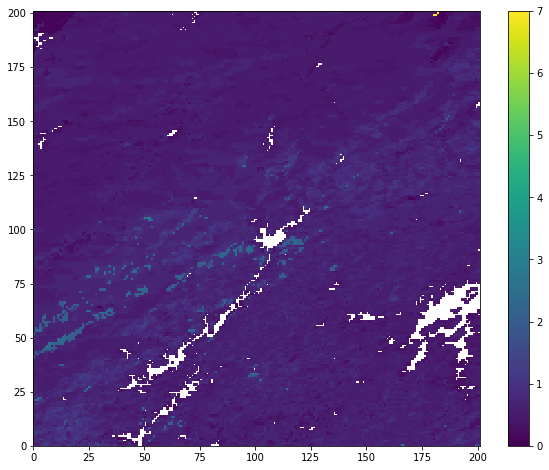

In [10]:
# We must flip the numpy array because GeoTIFF format origin is UL and our data origin is LL
band1 = np.ma.masked_greater( np.flipud( ras.read(1) ), 100 ) * float( meta['scale'] ) 

fig, ax = plt.subplots(figsize=(10,8))
im = ax.pcolormesh(band1)
fig.colorbar(im)

**Let's use rasterio's wrapper for the `gdalwarp` to create a warped virtual raster and plot:**

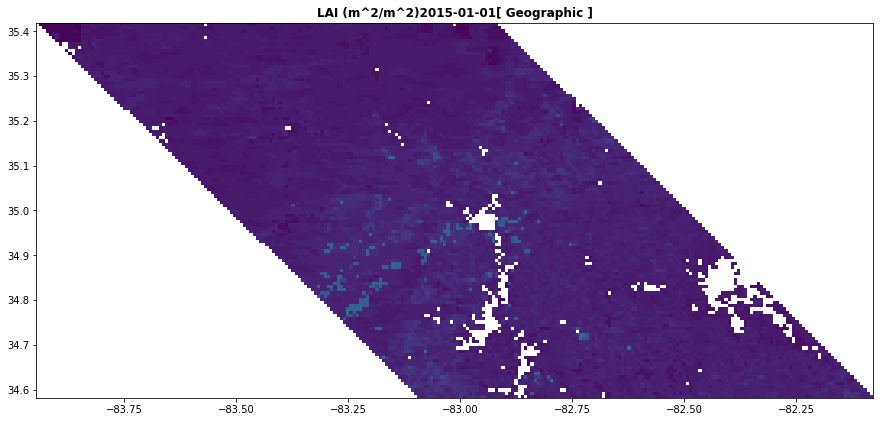

In [11]:
plt.rcParams['figure.figsize'] = (15,15)

from rasterio.vrt import WarpedVRT
from rasterio.plot import show

with WarpedVRT( ras, crs='EPSG:4326') as vrt:

    band1 = np.ma.masked_greater( vrt.read(1), 100 ) * float( meta['scale'] )
    show(band1, transform=vrt.transform, title = "LAI (m^2/m^2)" + list(data.keys())[0] + "[ Geographic ]")

**Write the dataset to a GeoTIFF:**

In [12]:
# save warped dataset output
ras.close()